In [11]:
import sys
import os
import pandas as pd
import numpy as np
import scanpy as sc
import torch
import json
import shutil
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from geneformer import Classifier
from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor

from transformers import (
    BertForMaskedLM,
    BertForSequenceClassification,
    BertForTokenClassification,
)

# Load the Model

In [2]:
torch.cuda.empty_cache()

def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        loaded_object = pickle.load(file)
    return loaded_object

def load_model(model_directory, id_class_dict_file):    
    class_dict = load_pickle_file(id_class_dict_file)
    num_classes = len(class_dict)
    
    model = BertForSequenceClassification.from_pretrained(
            model_directory,
            num_labels=num_classes,
            output_hidden_states=True,
            output_attentions=False,
        )
    
    model.eval()
    model = model.to("cuda")
    return model, class_dict


model_directory = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/finetuned_models/merged_adata/240923_geneformer_cellClassifier_hsc/ksplit1/"
id_class_dict_file = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/finetuned_models/merged_adata/hsc_id_class_dict.pkl"
model, class_dict = load_model(model_directory, id_class_dict_file)
print('done!')

done!


# Load the Data

In [3]:
torch.cuda.empty_cache()

fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/tokenized_data/merged_adata.dataset"
data = load_from_disk(fpath)
data = data.filter(lambda x: x['standard_cell_type'] == 'iHSC') 
data

Dataset({
    features: ['n_genes', 'dataset_x', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'dataset_y', 'standard_cell_type', 'cell_id', 'input_ids', 'length', 'total_length'],
    num_rows: 8379
})

In [7]:
torch.cuda.empty_cache()
    
def find_largest_div(N, K):
    rem = N % K
    if rem == 0:
        return N
    else:
        return N - rem
    
    
def classifier_predict(model, data, class_dict, forward_batch_size=200, label_name='standard_cell_type'):
    predict_logits = []
    
    model.eval()
    evalset_len = len(data)
    
    def get_attention_mask(row):
        row["attention_mask"] = (
            np.where(row["input_ids"] == 0.0, False, True)  # PAD TOKEN IS 0
        ).astype(int)
        return row
        
    for i in range(0, evalset_len, forward_batch_size):
        max_range = min(i + forward_batch_size, evalset_len)
        batch = data.select([i for i in range(i, max_range)])
        batch = batch.map(get_attention_mask)
        
        batch.set_format(type="torch")    
        with torch.no_grad():
            outputs = model(
                input_ids=batch['input_ids'].to("cuda"),
                attention_mask=batch['attention_mask'].to("cuda"),
            )
            predict_logits += [torch.squeeze(outputs.logits.to("cpu"))]
            
    # Apply softmax to get probabilities
    preds = torch.softmax(torch.cat(predict_logits), dim=1) 
    preds = pd.DataFrame(preds.numpy())
    preds.columns = [class_dict[x] for x in preds.columns]
    return preds
            
preds = classifier_predict(model, data, class_dict)
print(f"{preds.shape=}")
preds.head()

preds.shape=(8379, 20)


,MDP,CLP,CMP,T_cell,Fib,MEP,LMPP,LinNeg,GMP,MKP,NK,MLP,MPP,PreBNK,Mono,EryP,Dendritic_cell,B_cell,HSC,None
0,6.466100e-07,1.704856e-07,8.326539e-08,0.000001,0.999983,4.024139e-07,1.008224e-06,5.533223e-07,3.662731e-07,4.150307e-07,1.069080e-06,0.000004,5.235543e-07,0.000002,8.473451e-07,0.000002,7.926232e-07,4.323337e-08,5.628409e-07,3.006259e-07
1,7.063045e-07,1.588980e-07,7.701610e-08,0.000001,0.999983,4.782306e-07,8.023310e-07,5.496914e-07,3.469096e-07,4.389315e-07,9.734007e-07,0.000003,4.695495e-07,0.000002,1.203602e-06,0.000003,9.501792e-07,4.745521e-08,7.525430e-07,3.441485e-07
2,7.052451e-07,1.874675e-07,9.978721e-08,0.000001,0.999981,4.617429e-07,1.063642e-06,6.154831e-07,4.118286e-07,4.312199e-07,1.412094e-06,0.000004,5.020879e-07,0.000002,9.916835e-07,0.000003,8.170274e-07,6.074721e-08,6.598146e-07,3.931012e-07
3,6.908883e-07,1.752546e-07,1.031039e-07,0.000001,0.999981,5.026324e-07,1.101138e-06,5.016560e-07,3.798956e-07,4.850443e-07,1.461084e-06,0.000004,6.348708e-07,0.000002,1.162472e-06,0.000003,7.623217e-07,5.954168e-08,8.260849e-07,5.292144e-07
4,7.402924e-07,1.839108e-07,8.578968e-08,0.000001,0.999982,4.949319e-07,9.726460e-07,5.963747e-07,3.911983e-07,4.739692e-07,1.049831e-06,0.000004,5.075132e-07,0.000002,1.036138e-06,0.000003,9.686693e-07,4.743370e-08,6.719266e-07,3.277330e-07


In [9]:
pdf = preds.copy()
pdf = pdf.reset_index(names='cell_id')
pdf = pd.melt(pdf, id_vars='cell_id')

pdf.head()

,cell_id,variable,value
0,0,MDP,6.466100e-07
1,1,MDP,7.063045e-07
2,2,MDP,7.052451e-07
3,3,MDP,6.908883e-07
4,4,MDP,7.402924e-07


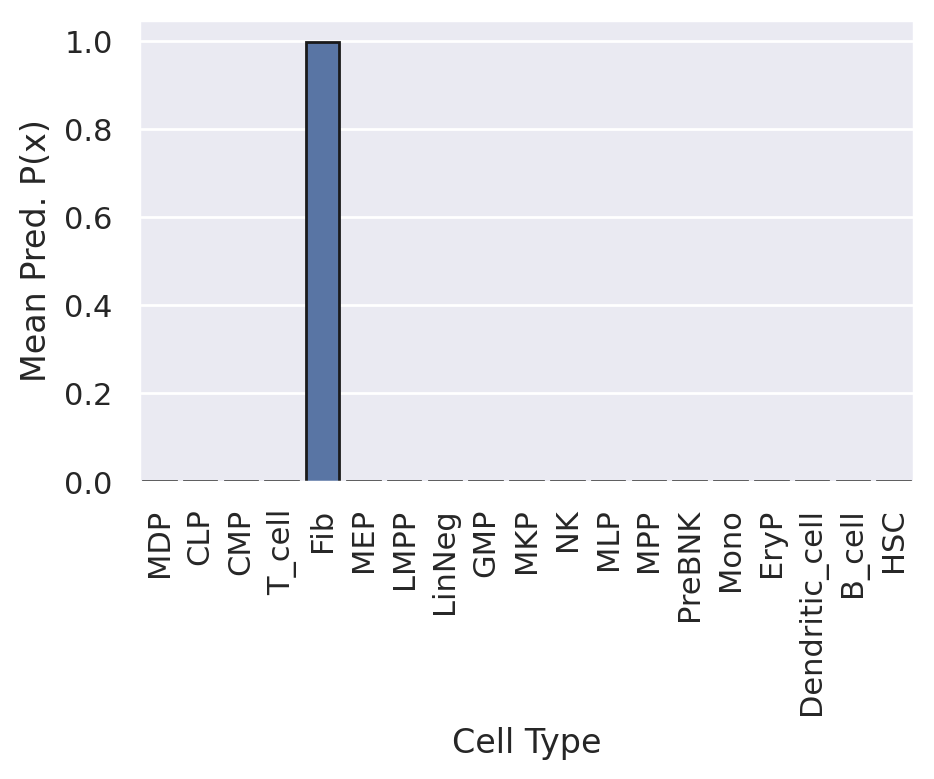

In [24]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.barplot(
    data=pdf,
    x='variable',
    y='value',
    ec='k',
)

plt.ylabel('Mean Pred. P(x)')
plt.xlabel('Cell Type')

plt.gca().tick_params(axis='x', rotation=90)

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
type(model)

In [ ]:
 elif model_type == "CellClassifier":
        model = BertForSequenceClassification.from_pretrained(
            model_directory,
            num_labels=num_classes,
            output_hidden_states=output_hidden_states,
            output_attentions=False,
        )
    # if eval mode, put the model in eval mode for fwd pass
    if mode == "eval":
        model.eval()

In [ ]:
?Classifier

In [ ]:
"""Load the model"""
model_path = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/finetuned_models/merged_adata/240923_geneformer_cellClassifier_hsc/ksplit1"
model = gtu.load_model(model_path)
print('loaded!')